<a href="https://colab.research.google.com/github/ShubhamP1028/DeepLearning/blob/main/LearningRates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Rates

Learning rate scheduling helps the model converge faster and avoid bad minima. Instead of keeping LR constant, we reduce it gradually (or cyclically) during training.

<b><u>what is Learning Rate?</u></b>
*  The learning rate is like the “step size” your model takes when learning.
*  If it’s too big, the model jumps around and misses the best spot.
*  If it’s too small, the model takes forever to reach the best spot.

---
<b><u>Why change the learning rate?</u></b>

Think of climbing down a mountain:
*  At the start, you want big steps to quickly cover distance.
*  Near the bottom (the optimal point), you want small careful steps so you don’t overshoot.

Learning rate schedules do exactly this:
*  High LR at start → fast learning.
*  Low LR later → fine-tuning.

---
### <u>Different Types of Learning Rate Schedules</u>
<b>1. Step Decay</b>
*  Learning rate drops suddenly after a fixed number of epochs.
*  Example: Start at 0.1 → after 10 epochs, reduce to 0.01 → after 20 epochs, reduce to 0.001.
*  🔎 Simple but a bit “jumpy”.

<b>2. Exponential Decay</b>
*  Learning rate decreases smoothly over time, not suddenly.
*  Formula:
$$
\text{LR}(t) = LR_0 \times e^{-\text{decay_rate} \times t}
$$
*  Example: If LR₀ = 0.1 and decay_rate = 0.1 → it shrinks gradually with each epoch.

<b>3. Polynomial Decay</b>
*  Decreases the LR following a polynomial curve (like 1/t²).
*  More flexible, can control how fast or slow LR reduces.

<b>4. Cosine Annealing</b>
*  Learning rate goes down like a wave (cosine curve).
*  Starts high → slowly drops → almost zero.
*  Looks smooth and natural.
*  Sometimes resets (warm restarts) to encourage the model to explore new paths.

<b>5. Cyclical Learning Rates (CLR)</b>
*  Instead of only going down, LR goes up and down in cycles.
*  Idea: small cycles help the model escape local traps and find better solutions.
*  Example: oscillates between 0.001 and 0.01.

<b>6. Warm-up</b>
*  Start with a very small LR (so model doesn’t explode at the beginning).
*  Gradually increase it to a bigger value.
*  Often used with Transformers and very large networks.

---
<b>Summary in Simple Words</b>

*  Learning rate schedule = changing the learning speed over time.
*  High at start → learn fast.
*  Low at end → learn carefully.

Different strategies (step, exponential, cosine, cyclic, warm-up) are just different ways of controlling how the “speed” changes.

---
We’ll implement common learning rate schedulers in PyTorch on your dataset:

*  StepLR → decreases LR every fixed number of epochs.
*  ExponentialLR → multiplies LR by a decay factor at each step.
*  ReduceLROnPlateau → reduces LR when validation loss stops improving.
*  CosineAnnealingLR → smooth cosine decay, popular in deep learning.




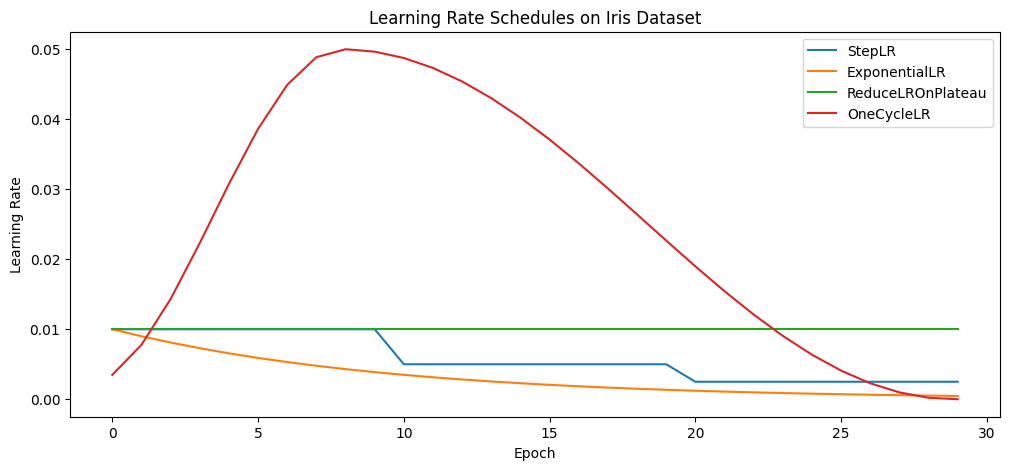

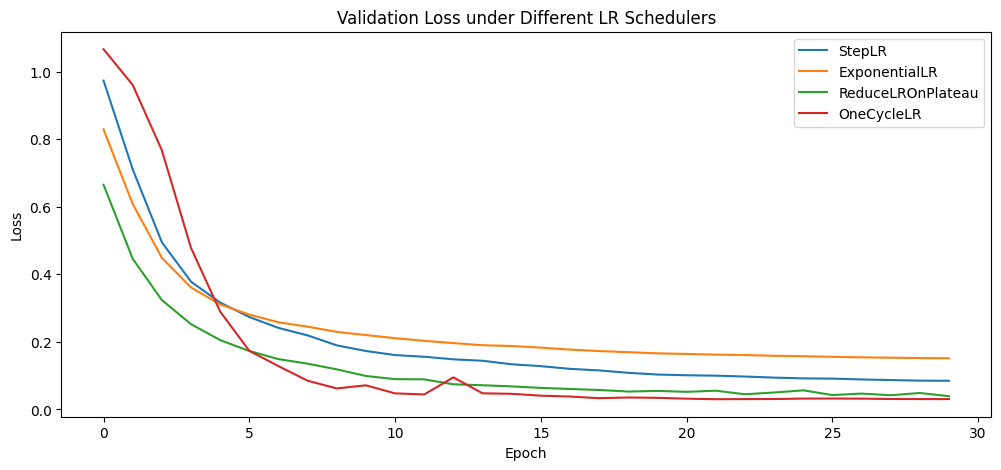

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau, OneCycleLR
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load & preprocess dataset
iris = load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# 2. Define simple NN model
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# 3. Training function
def train_model(scheduler_type, epochs=30):
    model = IrisNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Scheduler setup
    if scheduler_type == "StepLR":
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    elif scheduler_type == "ExponentialLR":
        scheduler = ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    elif scheduler_type == "OneCycleLR":
        scheduler = OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=len(train_loader), epochs=epochs)
    else:
        scheduler = None

    lr_history, loss_history = [], []

    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # Step scheduler
            if scheduler_type == "OneCycleLR":
                scheduler.step()

        # Validation loss for schedulers
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()

        loss_history.append(val_loss)
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Step other schedulers
        if scheduler_type in ["StepLR", "ExponentialLR"]:
            scheduler.step()
        elif scheduler_type == "ReduceLROnPlateau":
            scheduler.step(val_loss)

    return lr_history, loss_history

# 4. Compare schedulers
schedulers = ["StepLR", "ExponentialLR", "ReduceLROnPlateau", "OneCycleLR"]
results = {}

for sch in schedulers:
    lr_hist, loss_hist = train_model(sch)
    results[sch] = (lr_hist, loss_hist)

# 5. Plot LR schedules
plt.figure(figsize=(12,5))
for sch in schedulers:
    plt.plot(results[sch][0], label=sch)
plt.title("Learning Rate Schedules on Iris Dataset")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

# 6. Plot Validation Loss
plt.figure(figsize=(12,5))
for sch in schedulers:
    plt.plot(results[sch][1], label=sch)
plt.title("Validation Loss under Different LR Schedulers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
